In [251]:
%load_ext autoreload
%autoreload 2

%cd /home/zyuanjue/repos/active-learning/mnistvae

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/zyuanjue/repos/active-learning/mnistvae


In [252]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
os.environ["TF_USE_NVLINK_FOR_PARALLEL_COMPILATION"] = "0"
p = os.environ["PATH"]
os.environ["PATH"] = f"{p}:/usr/local/cuda/bin"

from functools import partial
import jax
import jax.numpy as jnp
from jaxtyping import PyTree
from torch.utils.data import DataLoader
import equinox as eqx
import matplotlib.pyplot as plt
import distrax as dsx
import optax
import seaborn as sns

import tensorflow_datasets as tfds
from typing import Iterator, Mapping, NamedTuple, Sequence, Tuple
import numpy as np

sns.set()

#from data import SpokenMNISTMultimodalDataset
from model.image_vae import ImageVAE, ImageVAEOutput
from model.loss import ELBOLossOutput, get_evidence_lower_bound
from model.visualization import visualize_reconstructions



BATCH_SIZE = 16

In [253]:
PRNGKey = jnp.ndarray
Batch = Mapping[str, np.ndarray]
batch_size = BATCH_SIZE
random_seed = 42

MNIST_IMAGE_SHAPE: Sequence[int] = (28, 28, 1)


def load_dataset(split: str, batch_size: int) -> Iterator[Batch]:
    ds = tfds.load(
        "binarized_mnist",
        split=split,
        shuffle_files=True,
        read_config=tfds.ReadConfig(shuffle_seed=random_seed),
    )
    ds = ds.shuffle(buffer_size=10 * batch_size, seed=random_seed)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=5)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))


In [254]:
train_dataloader = load_dataset(tfds.Split.TRAIN, batch_size)
test_dataloader = load_dataset(tfds.Split.TEST, batch_size)

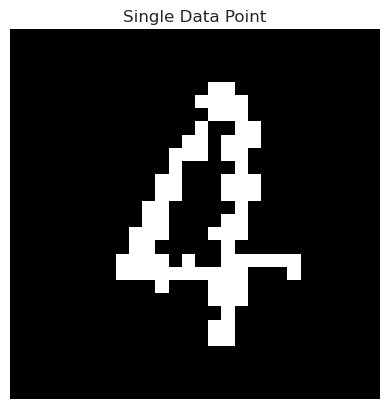

In [255]:
batch = next(train_dataloader)

# Take the first data point from the batch
data_point = batch['image'][0]
plt.imshow(data_point.squeeze(), cmap='gray')  # Use 'gray' for grayscale images
plt.title('Single Data Point')
plt.axis('off')
plt.show()

In [256]:
from model.encoder import ImageEncoder

key = jax.random.PRNGKey(0)
encoder = ImageEncoder(in_channels=1, out_channels=2, key=key)
encoder_fn = jax.vmap(encoder)


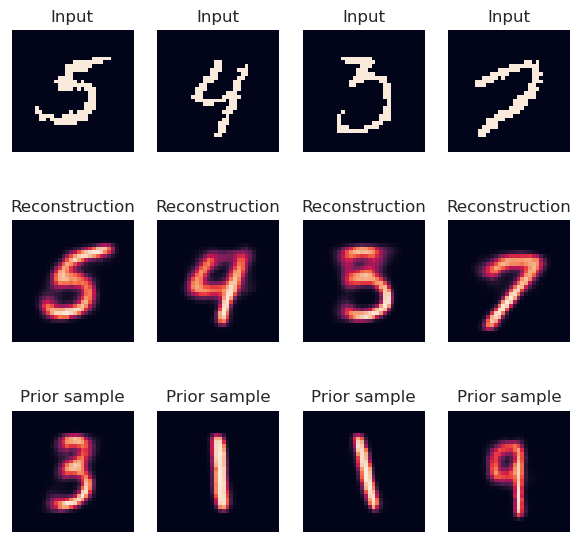

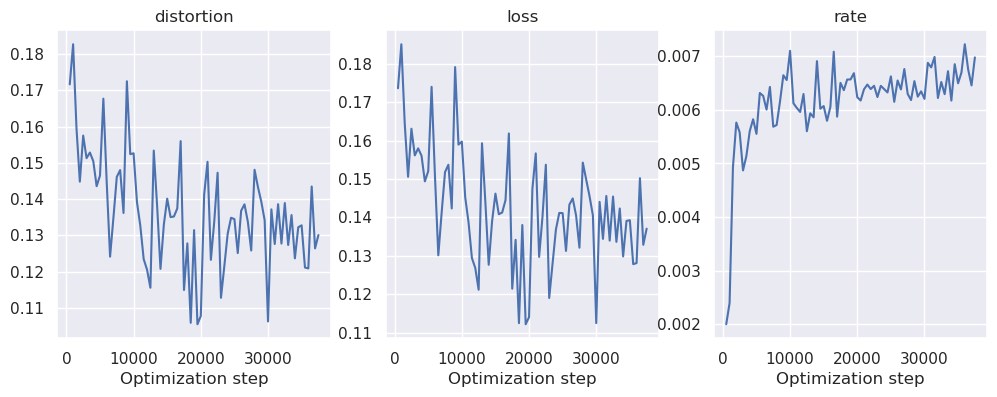

In [257]:
key = jax.random.PRNGKey(0)

model_key, key = jax.random.split(key)
model = ImageVAE(in_channels=1, n_latents=2, key=model_key)

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

pad_fn = jax.vmap(partial(jnp.pad, pad_width=2))


@eqx.filter_value_and_grad(has_aux=True)
def grad_and_loss(model: eqx.Module, batch: jnp.array, key: jax.random.PRNGKey):
    model_fn = jax.vmap(model)
    loss_fn = jax.vmap(get_evidence_lower_bound)
    keys = jax.random.split(key, BATCH_SIZE)
    model_output: ImageVAEOutput = model_fn(batch, key=keys)
    loss_output: ELBOLossOutput = loss_fn(batch, model_output)
    return jnp.mean(loss_output["loss"]), jax.tree_map(jnp.mean, loss_output)



@eqx.filter_jit
def make_step(
    model: eqx.Module,
    opt_state: PyTree,
    batch: jnp.array,
    *,
    key: jax.random.PRNGKey,
):
    (loss, aux), grads = grad_and_loss(model, batch, key)
    updates, update_opt_state = optimizer.update(grads, opt_state)
    update_model = eqx.apply_updates(model, updates)
    return (loss, aux), update_model, update_opt_state

MAX_EPOCHS = 10
steps_per_epoch = 60000 // batch_size 

step = 0  
train_metrics = None

for epoch in range(MAX_EPOCHS):
    for batch in train_dataloader:
        batch = jnp.asarray(batch["image"]).astype(jnp.float32)
        batch = np.squeeze(batch)
        targets = pad_fn(batch)
        key, binarized_key = jax.random.split(key)
        targets = (
            dsx.Bernoulli(probs=targets).sample(seed=binarized_key).astype(jnp.float32)
        )
        key, step_key = jax.random.split(key)
        (loss, aux), model, opt_state = make_step(
            model, opt_state, targets, key=step_key
        )

        step += 1
        if step % 500 == 0:
            if train_metrics is None:
                train_metrics = {k: jnp.array([v]) for k, v in aux.items()}
                train_metrics["step"] = jnp.array([step])
            else:
                for k, v in aux.items():
                    train_metrics[k] = jnp.concatenate(
                        [train_metrics[k], jnp.array([v])]
                    )
                train_metrics["step"] = jnp.concatenate(
                    [train_metrics["step"], jnp.array([step])]
                )

        log_str = f"step/epoch: {step}/{epoch}"
        for k, v in aux.items():
            log_str += f"\t {k}: {v:.3f}"
        #print(log_str)

        # Check if the epoch is completed
        if step % steps_per_epoch == 0:
            break  # End the current epoch

# Reset step for the next epoch or other post-epoch processing


visualize_reconstructions(model, targets)

K = len(train_metrics) - 1
plt.figure(figsize=(4 * K, 4))
for i, (k, v) in enumerate(train_metrics.items()):
    if k == "step":
        continue
    plt.subplot(1, K, i + 1)
    plt.title(k)
    plt.plot(train_metrics["step"], v)
    plt.xlabel("Optimization step")

In [171]:
from acquiring.sample_image import sample_a_image, get_next,update_images, binary_cross_entropy

In [172]:
BATCH_SIZE = 128
train_dataloader = load_dataset(tfds.Split.TRAIN, BATCH_SIZE)
batch = next(train_dataloader)
batch['image'].shape

2023-11-26 22:10:40.468839: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(128, 28, 28, 1)

In [173]:
#Pre_Process:
Nz = 10
Nx = 5


sample_a_image_fn = jax.vmap(sample_a_image, in_axes=(None, None, 0, None, 0))
get_next_fn = jax.vmap(get_next)
update_images_fn = jax.vmap(update_images)


model_fn = jax.vmap(model)
keys = jax.random.split(key, BATCH_SIZE)

In [180]:
def update(images_refill: jnp.ndarray, orginial_images: jnp.ndarray, images: jnp.ndarray, mask_observed: jnp.ndarray, rng):
    batch_rng = jax.random.split(rng, BATCH_SIZE) 
    model_output: ImageVAEOutput = model_fn(images_refill, key=batch_rng)
    R = sample_a_image_fn(Nz, Nx,model_output,model, batch_rng)
    images_updated, mask_return = get_next_fn(R, mask_observed, images,orginial_images)
    return images_updated, mask_return

In [175]:
from acquiring.sample_image import random_get_next


In [181]:

from acquiring.sample_image import random_get_next

def random_update(original_images,images: jnp.ndarray, mask_observed: jnp.ndarray, rng):
    images_updated, mask_return = random_get_next(mask_observed, images, original_images, rng)

    return images_updated, mask_return

In [242]:

num_batches_to_process = 10
display_batch_number = 0 
batch_counter = 0
log_likelihood = []
recon_value = []
step_numbers = []
for batch_index, batch in enumerate(train_dataloader):
    
    # Load and preprocess the batch
    original_images = np.squeeze(batch['image'])
    original_images = original_images.astype(np.float32)
    images_float = original_images
    half_height = images_float.shape[1] // 2

    # Create mask and images with missing data
    images_with_top_half_missing = images_float.copy()
    images_with_top_half_missing[:, :half_height, :] = np.nan
    mask_missing = np.isnan(images_with_top_half_missing)
    mask_observed = ~mask_missing


    images_refill = update_images_fn(original_images, mask_observed)
    mask_observed = pad_fn(mask_observed)
    images_refill = pad_fn(images_refill)
    original_images= pad_fn(original_images)


    current_images = images_refill
    current_mask = mask_observed

    steps = 20  # Log likelihood calculation frequency
    step_counter = 0
    max_step = 300


    if batch_index == display_batch_number:
        #print("here")
        original_random = original_images.copy()
        images_random = images_refill.copy() 
        mask_random = mask_observed.copy()

    # Processing loop
    while np.any(~mask_observed) and step_counter < max_step:
        current_images, current_mask = update(images_refill, original_images, current_images, current_mask, key)
        

        if step_counter % steps == 0 :
            # Log likelihood calculation for reconstruction
            new_log_likelihood_recon = -binary_cross_entropy(original_images, current_images)
            log_likelihood.append(-new_log_likelihood_recon)
            #print(f"Step {step_counter}:  Log Likelihood = {new_log_likelihood_recon[0]}")
            if batch_index == display_batch_number:
                print(f"Step {step_counter}:  Log Likelihood = {new_log_likelihood_recon[0]}")
                #print("here!!")
                recon_value.append(new_log_likelihood_recon[0])
                step_numbers.append(step_counter)
            #get plot for the first image
            # if step_counter < 100:
            #     plt.imshow(current_images[0], cmap='Blues', vmin=0, vmax=1)
            #     plt.colorbar()
            #     plt.show()
        step_counter += 1
    

    batch_counter += 1

    # Break the loop if the desired number of batches have been processed
    if batch_counter >= num_batches_to_process:
        break



Step 0:  Log Likelihood = -678.6322021484375
Step 20:  Log Likelihood = -673.3138427734375
Step 40:  Log Likelihood = -666.475830078125
Step 60:  Log Likelihood = -663.056884765625
Step 80:  Log Likelihood = -657.358642578125
Step 100:  Log Likelihood = -655.839111328125
Step 120:  Log Likelihood = -655.839111328125
Step 140:  Log Likelihood = -655.839111328125
Step 160:  Log Likelihood = -655.839111328125
Step 180:  Log Likelihood = -655.839111328125
Step 200:  Log Likelihood = -655.839111328125
Step 220:  Log Likelihood = -655.839111328125
Step 240:  Log Likelihood = -655.839111328125
Step 260:  Log Likelihood = -655.839111328125
Step 280:  Log Likelihood = -655.839111328125
Step 0:  Log Likelihood = -685.8500366210938
Step 20:  Log Likelihood = -683.1908569335938
Step 40:  Log Likelihood = -680.5316162109375
Step 60:  Log Likelihood = -679.0120849609375
Step 80:  Log Likelihood = -675.2131958007812
Step 100:  Log Likelihood = -674.8333129882812
Step 120:  Log Likelihood = -674.83331

In [243]:
reshaped_batches =jnp.array(log_likelihood).reshape(num_batches_to_process, step_counter // steps, BATCH_SIZE).transpose(1, 0, 2)

combined_batches = reshaped_batches.reshape(step_counter // steps, num_batches_to_process * BATCH_SIZE ) # shape is (15, n*128)

std_dev_each_step = np.std(combined_batches, axis=1, keepdims=True)
std_dev_each_step.shape

(15, 1)

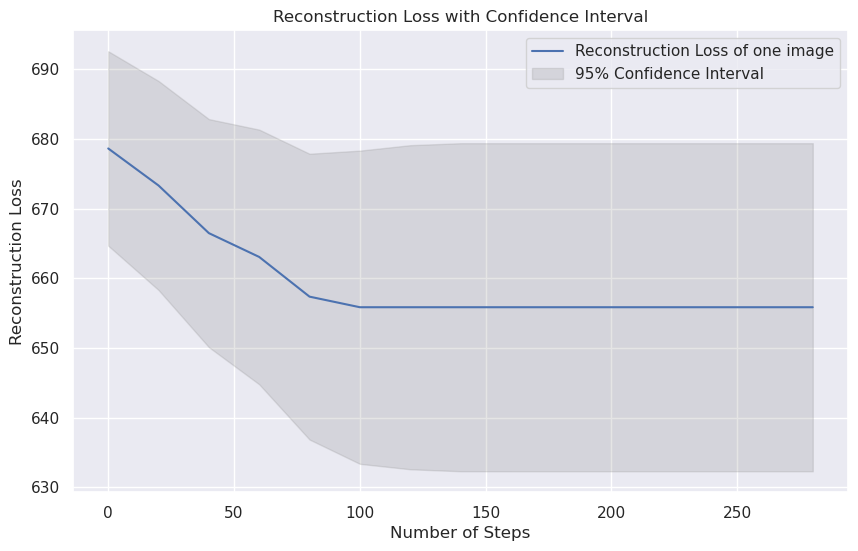

In [245]:
recon_value = -jnp.array(recon_value)

std_deviation = std_dev_each_step

ci = 1.96 * std_deviation.flatten()  # Flatten to ensure it's a 1D array
lower_bound = recon_value - ci
upper_bound = recon_value + ci

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(step_numbers, recon_value, label='Reconstruction Loss of one image')
plt.fill_between(step_numbers, lower_bound, upper_bound, color='gray', alpha=0.2, label='95% Confidence Interval')
plt.title('Reconstruction Loss with Confidence Interval')
plt.xlabel('Number of Steps')
plt.ylabel('Reconstruction Loss')
plt.legend()
plt.show()

In [246]:

from acquiring.sample_image import random_get_next
def random_update(images: jnp.ndarray, mask_observed: jnp.ndarray, rng):
    images_updated, mask_return = random_get_next(mask_observed, images, original_random, rng)
    return images_updated, mask_return

In [248]:
inital_images = images_random
initial_mask = mask_random
current_images = inital_images
current_mask = initial_mask
        # original_random = original_images.copy()
        # images_random = images_refill.copy() 
        # mask_random = mask_observed.copy()

steps = 20  # Calculate log likelihood every 100 steps
step_counter = 0
max_step = 300
random_value = []
step_numbers = [] 
while np.any(~mask_observed) and step_counter< max_step:
    current_images, current_mask = random_update(current_images, current_mask, key)
    
    if step_counter % steps == 0:
        new_log_likelihood = -binary_cross_entropy(original_random, current_images)
        mean_log_likelihood = jnp.mean(new_log_likelihood)
        random_value.append(-mean_log_likelihood)
        step_numbers.append(step_counter)
        print(f"Step {step_counter}: Mean Log Likelihood = {mean_log_likelihood}")
    # if step_counter % steps == 0 and step_counter < 100:
    #     plt.imshow(current_images[0], cmap='Blues', vmin=0, vmax=1)
    #     plt.colorbar()
    #     plt.show()
        
    step_counter += 1

Step 0: Mean Log Likelihood = -690.049560546875
Step 20: Mean Log Likelihood = -689.9575805664062
Step 40: Mean Log Likelihood = -689.785400390625
Step 60: Mean Log Likelihood = -689.6964111328125
Step 80: Mean Log Likelihood = -689.515380859375
Step 100: Mean Log Likelihood = -689.402587890625
Step 120: Mean Log Likelihood = -689.2957763671875
Step 140: Mean Log Likelihood = -689.19189453125
Step 160: Mean Log Likelihood = -688.9633178710938
Step 180: Mean Log Likelihood = -688.8386840820312
Step 200: Mean Log Likelihood = -688.6754760742188
Step 220: Mean Log Likelihood = -688.565673828125
Step 240: Mean Log Likelihood = -688.4231567382812
Step 260: Mean Log Likelihood = -688.265869140625
Step 280: Mean Log Likelihood = -688.1768798828125


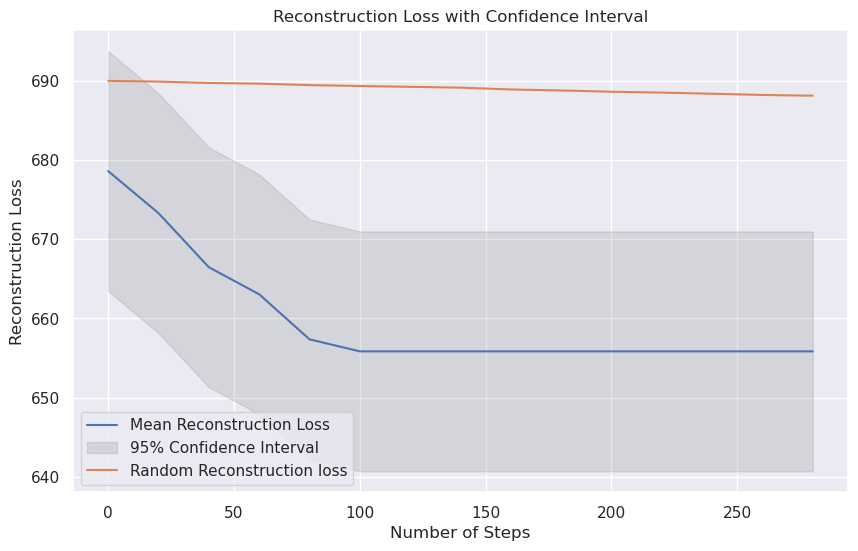

In [249]:
recon_value = np.array(recon_value)
std_deviation = jnp.std(new_log_likelihood)

# Calculate the upper and lower bounds of the confidence interval
ci = 1.96 * std_deviation  # 95% confidence interval for a normal distribution
lower_bound = recon_value - ci
upper_bound = recon_value + ci

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(step_numbers, recon_value, label='Mean Reconstruction Loss')
plt.fill_between(step_numbers, lower_bound, upper_bound, color='gray', alpha=0.2, label='95% Confidence Interval')
plt.plot(step_numbers, random_value, label= "Random Reconstruction loss" )
plt.title('Reconstruction Loss with Confidence Interval')
plt.xlabel('Number of Steps')
plt.ylabel('Reconstruction Loss')
plt.legend()
plt.show()